In [71]:
from tonic.datasets.nmnist import NMNIST
from torch import nn
from torch.nn import functional as F
import torch
from torch.utils.data import DataLoader
from torch.optim import SGD
from tqdm import tqdm
from torch.nn import CrossEntropyLoss
import matplotlib.pyplot as plt
import math
import numpy as np

root_dir = './nmnist'
_ = NMNIST(save_to=root_dir, train=True)
_ = NMNIST(save_to=root_dir, train=False)

In [72]:
from tonic.transforms import ToFrame
from tonic.datasets import nmnist

batch_size = 1
num_workers = 4
device = "cuda:0"
shuffle = False

# Transform that accumulates events into single frame image
to_frame = ToFrame(sensor_size=NMNIST.sensor_size, n_time_bins=1)

train_dataset = NMNIST(save_to=root_dir, train=True, transform=to_frame)
test_dataset = NMNIST(save_to=root_dir, train=False, transform=to_frame)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, drop_last=True, shuffle=shuffle)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers, drop_last=True, shuffle=shuffle)

torch.Size([2, 34, 34])


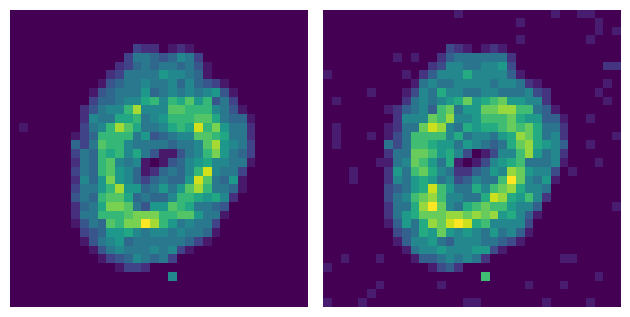

In [73]:
%matplotlib inline
import matplotlib.pyplot as plt
for d, _ in test_dataloader:
    sample_data = d
    break

frames = sample_data.squeeze()
print(frames.shape)
fig, axes = plt.subplots(1, 2)
axes[0].imshow(frames[0])
axes[0].axis('off')
axes[1].imshow(frames[1])
axes[1].axis('off')
plt.tight_layout()

In [75]:
model_linear = nn.Sequential(
    # [2, 34, 34] -> [10]
    nn.Linear(2 * 34 * 34, 10),
    nn.ReLU(),
)

In [76]:
model_conv_linear = nn.Sequential(
    # [2, 34, 34] -> [8, 17, 17]
    nn.Conv2d(in_channels=2, out_channels=8, kernel_size=(3,3), padding=(1,1), bias=False),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(9248, 10, bias=False),
    nn.ReLU()
)

In [77]:
model_conv_avg_linear = nn.Sequential(
    # [2, 34, 34] -> [8, 17, 17]
    nn.Conv2d(in_channels=2, out_channels=8, kernel_size=(3,3), padding=(1,1), bias=False),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(9248, 10, bias=False),
    nn.ReLU()
)

In [78]:
model_sinabs = nn.Sequential(
    # [2, 34, 34] -> [8, 17, 17]
    nn.Conv2d(in_channels=2, out_channels=8, kernel_size=(3,3), padding=(1,1), bias=False),
    nn.ReLU(),
    nn.AvgPool2d(2, 2),
    
    # [8, 17, 17] -> [16, 8, 8]
    nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3,3), padding=(1,1), bias=False),
    nn.ReLU(),
    nn.AvgPool2d(2,2),
    
    # [16, 8, 8] -> [16, 4, 4]
    nn.Conv2d(in_channels=16, out_channels=16, kernel_size = (3,3), padding=(1,1), stride=(2,2), bias=False),
    nn.ReLU(),
    
    # [16 * 4 * 4] -> [10]
    nn.Flatten(),
    nn.Linear(16 * 4 * 4, 10, bias=False),
    nn.ReLU()
)

In [79]:
mob = model_sinabs
mob = nn.Sequential(
    nn.Linear(784, 200),
    nn.ReLU(),
    nn.Linear(200, 100),
    nn.ReLU(),
    nn.Linear(100, 10))
torch.save(mob.state_dict(), "./weights/bleh.pth")
model_weights = torch.load("./weights/bleh.pth")


/tmp/ipykernel_2422283/4252821774.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_weights = torch.load("./weights/bleh.pth")


In [108]:
w = model_weights['0.weight']
w.shape

torch.Size([8, 2, 3, 3])

In [81]:
model = model_sinabs
model_weights = torch.load("./weights/model-weights.pth")
model.load_state_dict(model_weights)

/tmp/ipykernel_2422283/3213821862.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_weights = torch.load("./weights/model-weights.pth")


<All keys matched successfully>

In [82]:
from sinabs.from_torch import from_model
import sinabs.activation.spike_generation as spikegen

snn = from_model(model=model, input_shape=(2, 34, 34), batch_size=1, spike_fn=spikegen.SingleSpike).spiking_model
snn

Sequential(
  (0): Conv2d(2, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): IAFSqueeze(spike_threshold=Parameter containing:
  tensor(1.), min_v_mem=Parameter containing:
  tensor(-1.), batch_size=1, num_timesteps=-1)
  (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (4): IAFSqueeze(spike_threshold=Parameter containing:
  tensor(1.), min_v_mem=Parameter containing:
  tensor(-1.), batch_size=1, num_timesteps=-1)
  (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (6): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (7): IAFSqueeze(spike_threshold=Parameter containing:
  tensor(1.), min_v_mem=Parameter containing:
  tensor(-1.), batch_size=1, num_timesteps=-1)
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=256, out_features=10, bias=False)
  (10): IAFSqueeze(spike_threshold=Parameter containing:
  tensor(1.), min_v_mem=Pa

In [83]:
n_time_steps = 100
to_raster = ToFrame(sensor_size=NMNIST.sensor_size, n_time_bins=n_time_steps)
snn_test_dataset = NMNIST(save_to=root_dir, train=False, transform=to_raster)
snn_test_dataloader = DataLoader(snn_test_dataset, batch_size=batch_size, num_workers=num_workers, drop_last=True, shuffle=False)

snn = snn.to(device)

In [96]:
sample_data, label = snn_test_dataset[1000]
print(sample_data.shape, label)
sample_data.save

(100, 2, 34, 34) 1
tensor([[1]], device='cuda:0')


In [13]:
_ = snn.to('cpu')
zeros = torch.zeros(sample_data.shape)
ones = torch.ones(sample_data.shape)

In [14]:
modules = list(snn.modules())[1:]
print(f'spike_threshold: {float(modules[1].spike_threshold)}\nmin_v_mem: {float(modules[1].min_v_mem)}')

spike_threshold: 1.0
min_v_mem: -1.0


In [15]:
conv = modules[0]
conv_out = conv(ones)
iaf = modules[1]
iaf_out = iaf(conv_out)

print(torch.min(conv_out), torch.max(conv_out))

tensor(-1.1638, grad_fn=<MinBackward1>) tensor(2.4432, grad_fn=<MaxBackward1>)


In [16]:
W = list(conv.parameters())[0]
W.shape
conv_out.shape

torch.Size([100, 8, 34, 34])

In [17]:
def plot_tensor(tensor, ax, printcb=False):
    if tensor.dim() != 2:
        raise ValueError("Input tensor must be a 2D tensor.")
    
    tensor_np = tensor.numpy()  # Convert to numpy array
    ax.imshow(tensor_np, cmap='coolwarm', aspect='equal')

    cax = ax.imshow(tensor_np, cmap='coolwarm', aspect='equal')
    if printcb:
        fig.colorbar(cax, ax=ax)  # Show color scale
    ax.axis('off')


In [18]:
def get_class_name(class_string):
    # Strip the angle brackets and split the string by dots
    split_string = class_string.strip("<>").split(".")
    # Get the last element from the split string
    class_name = split_string[-1]
    # Remove the ending single quote if it exists
    return class_name.strip("'")

torch.Size([1, 5, 30, 100])


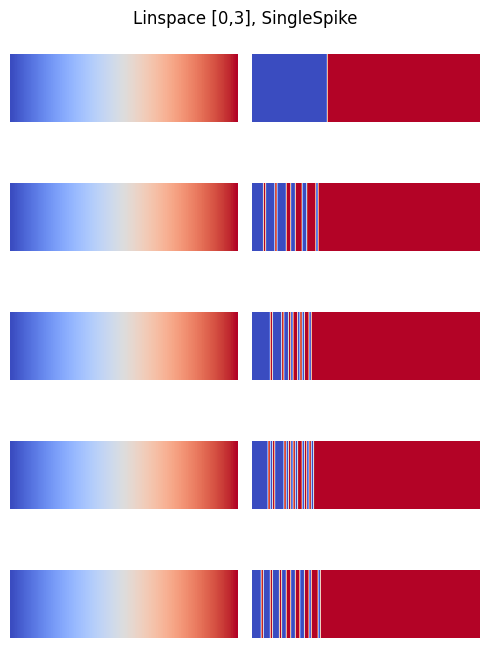

In [19]:
from sinabs.layers import IAF,LIF

import numpy as np

#tensor = torch.rand((1, 2, 34, 34))
#tensor[0,1] = tensor[0,0]
begin = 0
end = 3
tensor = torch.linspace(begin, end, steps=100).repeat(30, 1)
iaf = IAF(spike_fn = spikegen.SingleSpike, record_states=True)

t = 5

image = tensor.unsqueeze(0)
image = torch.stack([image] * t, dim=1)

title = f'Linspace [{begin},{end}], {get_class_name(str(iaf.spike_fn))}'

# image[0, 1:3] = torch.zeros((30, 100))
# image[0, 3] = torch.zeros((30, 100))
# title += ', with interruptions'
#image = sample_data[10].unsqueeze(0).cpu()
print(image.shape)
fig, ax = plt.subplots(image.shape[1], 2, figsize=(5,7))
for i in range(image.shape[1]):
    with torch.no_grad():
        plot_tensor(image[0,i], ax[i,0])
        plot_tensor(iaf(image)[0,i], ax[i, 1])


plt.tight_layout()
fig.suptitle(title)
plt.show()


In [20]:
recordings = iaf.recordings['v_mem']
x = 30
y = 0
print(recordings.shape)
print(image[0, 0, y, x])
for i in range(recordings.shape[1]):
    print(f'{float(image[0,i,y,x]):.4f} -> {float(recordings[0,i,y,x]):.4f}')


torch.Size([1, 5, 30, 100])
tensor(0.9091)
0.9091 -> 0.0909
0.9091 -> 0.0000
0.9091 -> 0.9091
0.9091 -> 0.8182
0.9091 -> 0.7273


In [21]:
def conv_layer(x: 'np.ndarray[np.float32]', W):
    C_in = W.shape[1]
    C_out = W.shape[0]
    kernel_size = tuple((W.shape[2:4]))
    timesteps = x.shape[0]
    stride = 1
    padding = (1,1)
    # Zero pad
    data_padded = torch.zeros(x.shape[0],
                              x.shape[1] + 2*padding[0],
                              x.shape[2] + 2*padding[0])
    data_padded[:, padding[0]:x.shape[1] + padding[0], padding[1]:x.shape[2] + padding[1]] = x.cpu()
    output = torch.zeros(C_out, x.shape[1], x.shape[2])
    
    coordinate_pairs = [(a, b) for a in range(0, x.shape[1], stride) for b in range(0, x.shape[2], stride)]
    for l in range(C_out):
        for k in range(C_in):
            kernel = W[l,k]
            for i, j in coordinate_pairs:
                i_pad = i + padding[0]
                j_pad = j + padding[1]
                for m_ in range(kernel_size[0]):
                    m = m_ - 1
                    for n_ in range(kernel_size[1]):
                        n = n_ -1
                        output[l, i, j] += (kernel[m_, n_]
                                            * data_padded[k, i_pad + m, j_pad + n])

    return output


x = torch.ones([2, 34, 34])
# sample_data.to('cpu')
# x = sample_data[0].to('cpu')
conv_theirs = conv(x)
conv_mine = conv_layer(x, W)



In [22]:
precision = 5
mine_round = torch.round(conv_mine * 10**precision) / 10**precision
theirs_round = torch.round(conv_theirs * 10**precision) / 10**precision
num_true = torch.sum(mine_round == theirs_round).item()
num_false = (mine_round==theirs_round).numel() - num_true
print(f'True: {num_true}, False: {num_false}')
false_indexes = torch.nonzero((conv_mine == conv_theirs) == False, as_tuple=False)
print(conv_theirs[0,0,0])
print(conv_mine[0,0,0])


True: 9248, False: 0
tensor(-0.2468, grad_fn=<SelectBackward0>)
tensor(-0.2468, grad_fn=<SelectBackward0>)


In [23]:
weights_np = W.detach().numpy() 
theirs_np = conv_theirs.detach().numpy()
mine_np = conv_mine.detach().numpy()

In [24]:
conv_mine.reshape(1, 1, 8, 34, 34).shape


torch.Size([1, 1, 8, 34, 34])

In [25]:
class if_layer:
    def __init__(self, input_shape):
        self.membrane = torch.zeros(input_shape)
        self.coordinate_pairs = [(a, b) for a in range(input_shape[1]) for b in range(input_shape[2])]
        self.v_th = 1.0
        
    def reset(self):
        self.membrane = torch.zeros(input_shape)
    def __call__(self, x: 'np.ndarray[np.float32]'):
        '''Basic implementation of IF layer.
        Assumptions:
        spike_threshold = 1.0,
        spike_fn = SingleSpike
        No batch, No timing: the FPGA simply runs everything on FIFO basis
        Thererofe, this has to be a class.
        x dimensions: [c, y, x]
        '''
        output = torch.zeros(self.membrane.shape)
        for c in range(x.shape[0]):
            for (i, j) in self.coordinate_pairs:
                self.membrane[c, i, j] +=  x[c, i, j]

                if self.membrane[c, i, j] > self.v_th:
                    output[c,i,j] = 1;
                    self.membrane[c, i, j] -= 1

        return output


In [26]:
class if1_layer:
    """Expect input shape: [time, channel, y, x]"""
    def __init__(self, input_shape, rec=None):
        self.timesteps = input_shape[0]
        self.elems = torch.tensor(input_shape[1:]).prod().item()
        self.membrane = torch.zeros([self.elems])
        if rec != None:
            self.recs = list()
            self.reci = torch.tensor(rec).prod().item()
        else:
            self.recs = None
        self.v_th = 1.0

    def reset(self):
        self.membrane = torch.zeros(input_shape)

    def __call__(self, x):
        input_shape = x.shape
        x = x.reshape((self.timesteps, self.elems))
        output = torch.zeros((self.timesteps, self.elems))
        recs = list()
        for t in range(self.timesteps):
            for e in range(self.elems):
                self.membrane[e] +=  x[t, e]
                if self.membrane[e] >= self.v_th:
                    output[t, e] = 1;
                    self.membrane[e] -= 1

                if self.membrane[e] < -1:
                    self.membrane[e] = -1
            if self.recs != None:
                self.recs.append(self.membrane[self.reci].item())

        output = output.reshape(input_shape)
        return output

In [27]:
data_me = torch.ones((100, 8, 34, 34)) * 0.2
data_them = data_me.unsqueeze(0)
print(data_me.shape, data_them.shape)

torch.Size([100, 8, 34, 34]) torch.Size([1, 100, 8, 34, 34])


In [28]:
def avg_pool2d(x):
    kernel = (2,2)
    stride = 2
    padding = 0

    # Create output buffer
    H_out = math.floor((x.shape[1] + (2 * padding) - kernel[0]) / stride) + 1
    W_out = math.floor((x.shape[2] + (2 * padding) - kernel[0]) / stride) + 1
    output = torch.zeros((x.shape[0], H_out, W_out))

    # Zero pad
    data_padded = torch.zeros(x.shape[0],
                              x.shape[1] + 2*padding,
                              x.shape[2] + 2*padding)
    data_padded[:, padding:x.shape[1] + padding, padding:x.shape[2] + padding] = x.cpu()

    coordinate_pairs = [(a, b) for a in range(H_out) for b in range(W_out)]
    coordinate_pairs.sort()
    kernel_pairs = [(a, b) for a in range(kernel[0]) for b in range(kernel[1])]
    kernel_pairs.sort()
    for c in range(output.shape[0]):
        for (h, w) in coordinate_pairs:
            # Apply kernel
            kernel_sum = 0
            for (m, n) in kernel_pairs:
                kernel_sum += data_padded[c, stride * h + m, stride * w + n]
            output[c, h, w] = 1 / (kernel[0] * kernel[1]) * kernel_sum

    return output                         

In [29]:
def get_module_name(input_string):
    input_string = str(input_string)
    # Pattern to match the function name and contents within first
    pattern = r"^([a-zA-Z_][a-zA-Z0-9_]*)\(.*"
    
    match = re.match(pattern, input_string)
    if match:
        return match.group(1)  # Return the function name
    else:
        return None  # If there's no match

# Weight Saving

In [30]:
import re
import datetime 
snn = from_model(model=model, input_shape=(2, 34, 34), batch_size=1, spike_fn=spikegen.SingleSpike).spiking_model.to('cpu')

with torch.no_grad():
    for (i, m) in enumerate(list(snn.modules())[1:]):
        mod_name = get_module_name(m)

        if mod_name == 'Conv2d' or mod_name == 'Linear':
            save_name = f'./weights/{i}-{mod_name}.npy'
            np.save(save_name, list(m.parameters())[0])
            print(f'Saved weights {save_name} : {list(m.parameters())[0].shape}')

        if mod_name == 'Flatten':
            m = nn.Flatten(start_dim=0)

print(f'\n[{datetime.datetime.now().isoformat()}] Saved weights')

Saved weights ./weights/0-Conv2d.npy : torch.Size([8, 2, 3, 3])
Saved weights ./weights/3-Conv2d.npy : torch.Size([16, 8, 3, 3])
Saved weights ./weights/6-Conv2d.npy : torch.Size([16, 16, 3, 3])
Saved weights ./weights/9-Linear.npy : torch.Size([10, 256])

[2024-09-26T14:52:23.508630] Saved weights


In [31]:
import re
import os
snn = from_model(model=model, input_shape=(2, 34, 34), batch_size=1, spike_fn=spikegen.SingleSpike).spiking_model.to('cpu')
mods = list(snn.modules())[1:]

mems = list()

# data = torch.tensor(np.load(f"tensors/datafile.npy"))
data = torch.tensor(np.load(f"./6174.npy")).to(dtype=torch.float, device='cpu')
print(f'Data Shape: {data.shape}\n')
outs = torch.zeros((data.shape[0], 10))

with torch.no_grad():
    end_of_data = False
    count = 0
    failed = False
    while not failed:
        if not os.path.isfile(f"tensors/x{count}.npy"):
            end_of_data = True
            break

        mod = mods[count % len(mods)]
        mod_name = get_module_name(mod)

        if count % len(mods) == 0:
            #print(f'\n====== BEGIN ITERATION {count // len(mods)} ======')
            batch = count // len(mods)
            x = data[batch].unsqueeze(0)
            #print(f'Input sum: {x.sum()}')

        # if (mod_name == 'IAFSqueeze'):
        #     mod.record_states = True

        # Get the data
        #print(f"Doing {mod_name}")
        x_hat = torch.tensor(np.load(f"tensors/x{count}.npy"))
        x_new = mod(x)

        # Handle wrong x case
        x_correct = torch.isclose(x_new, x_hat, atol=1e-5)
        correctness = torch.unique(x_correct)
        if len(correctness) != 1 and correctness[0] == True:
            failed = True
            print(f'Failed at {mod_name}[{count % len(mods)}]')
            wrong_idx = torch.stack(torch.where(x_correct == False), dim=1)
            print(f'Total wrong {wrong_idx.shape[0]}')
            for i in range(3):
                r = torch.randint(0, wrong_idx.shape[0], (1,))
                row = tuple(*(wrong_idx[r].tolist()))
                print(f'Example {row}: {x_new[row]:.5f} != {x_hat.unsqueeze(0)[row]:.5f}')


        if mod_name == 'Conv2d' and failed:
            wrong_idx = torch.stack(torch.where(x_correct == False), dim=1)
            # Check if error is on padding
            non_boundary = False
            for k in range(wrong_idx.shape[0]):
                row = wrong_idx[k]
                zeros = row[2] == 0 or row[3] == 0
                limits = row[2] == x_new.shape[-2]-1 or row[3] == x_new.shape[-1]-1
                if not (zeros or limits):
                    print(f'Found non-boundary error: {row}')
                    non_boundary = True

            if not non_boundary:
                print(f'convolution: all errors reside on boundary. Consider checking padding implementation.')
            
        
        # if mod_name == 'IAFSqueeze':
        #     recordings = mod.recordings['v_mem']
        #     recordings_hat = torch.tensor(np.load(f"tensors/membrane{count}.npy")).reshape(recordings.shape)

        #     mem_correct = torch.isclose(recordings_hat, recordings, atol=1e-5)
        #     # print(f'IAF[{count % len(mods)}] Unique non-zero recordings: {len(torch.unique(recordings))-1}')
        #     # print(f'IAF[{count % len(mods)}] Firings: {int(x_new.sum())}')
        #     if len(torch.unique(mem_correct)) != 1 and torch.unique(mem_correct)[0] == True:
        #         failed = True
        #         print(f'Failed at {mod_name} - Membrane mismatch')
        #         wrong_idx = torch.where(mem_correct == False)
        #         wrong_i = 1
        #         ex_pos = (int(wrong_idx[0][wrong_i]), int(wrong_idx[1][wrong_i]),
        #                   int(wrong_idx[2][wrong_i]), int(wrong_idx[3][wrong_i]),
        #                   int(wrong_idx[4][wrong_i]))
        #         print(f'Example: {ex_pos}: {recordings[ex_pos]} != {recordings_hat[ex_pos[2:]]}')

            
        if (count+1) % len(mods) == 0:
            outs[batch] = x_new[0]
        x = x_new
        count += 1
    if failed:
        print(f'\nStopped: count {count}')
    else:
        print(f'\nTest completed successfully.')
        prediction = outs.sum(dim=0).argmax(dim=0, keepdim=True)
        print(f'Prediction: {prediction.item()}')


FileNotFoundError: [Errno 2] No such file or directory: './6174.npy'

In [32]:
datai = 6174
for i, (realdata, label) in enumerate(snn_test_dataloader):
    if i == datai:
        realdata = realdata.squeeze(0)
        np.save(f"./tensors/torch-datafile.npy", realdata)

In [33]:
import re
import os

# Grab the data
#data = torch.tensor(np.load(f"tensors/{datai}.npy"))
data = torch.tensor(np.load(f"./{datai}.npy")).to(dtype=torch.float, device='cpu')
print(f'Data Shape: {data.shape}\n')

# Run through real network
snn = from_model(model=model, input_shape=(2, 34, 34), batch_size=1, spike_fn=spikegen.SingleSpike).spiking_model.to('cpu')
snn.eval()
with torch.no_grad():
    mods = list(snn.modules())[1:]
    output = data
    for m in mods:
        output = m(output)
        print(m)
        print(output.shape)
    lol()
    prediction = output.sum(dim=0).argmax(dim=0, keepdim=True)
    print(f'Prediction: {prediction.item()}')

FileNotFoundError: [Errno 2] No such file or directory: './6174.npy'

In [34]:
for i, (realdata, label) in enumerate(snn_test_dataloader):
    if i == datai:
        realdata = realdata.squeeze(0)
        np.save(f"./{i}.npy", realdata)
        print(realdata.shape, data.shape)
        print(f"label: {label.item()}")

        wrong_idx = torch.stack(torch.where(realdata != data), dim=1)
        print(f'Total wrong {wrong_idx.shape[0]}')
        torch.manual_seed(0)
        if wrong_idx.shape[0] > 0:
            for i in range(3):
                r = torch.randint(0, wrong_idx.shape[0], (1,))
                row = tuple(*(wrong_idx[r].tolist()))
                print(f'Example {row}: {data[row]:.5f} != {realdata[row]:.5f}')

        break

NameError: name 'data' is not defined

In [35]:
# Reset the snn for testing
for m in mods:
    mod_name = get_module_name(m)
    if mod_name == "IAFSqueeze":
        m.reset_states()
        
n_time_steps = 100
to_raster = ToFrame(sensor_size=NMNIST.sensor_size, n_time_bins=n_time_steps)
snn_test_dataset = NMNIST(save_to=root_dir, train=False, transform=to_raster)
snn_test_dataloader = DataLoader(snn_test_dataset, batch_size=batch_size, num_workers=num_workers, drop_last=True, shuffle=False)
snn = from_model(model=model, input_shape=(2, 34, 34), batch_size=1, spike_fn=spikegen.SingleSpike).spiking_model.to('cpu')

correct_predictions = []
with torch.no_grad():
    test_p_bar = tqdm(snn_test_dataloader,  desc=f'Testing model.', mininterval=1)
    for data, label in test_p_bar:

        # reshape the input from [Batch, Time, Channel, Height, Width] into [Batch*Time, Channel, Height, Width]
        data = data.reshape(-1, 2, 34, 34).to(dtype=torch.float, device='cpu')
        # forward
        modules = list(snn.modules())[1:]
        output = data
        for m in modules:
            output = m(output)
        # reshape the output from [Batch*Time,num_classes] into [Batch, Time, num_classes]
        output = output.reshape(batch_size, n_time_steps, -1)
        # accumulate all time-steps output for final prediction
        output = output.sum(dim=1)
        # calculate accuracy
        pred = output.argmax(dim=1, keepdim=True)
        # compute the total correct predictions
        correct_predictions.append(pred.eq(label.view_as(pred)))
        # set progressing bar
        test_p_bar.update()
        #test_p_bar.set_description(f"Testing SNN Model...")

    correct_predictions = torch.cat(correct_predictions)
    print(f"\nAccuracy of converted SNN: {correct_predictions.sum().item()/(len(correct_predictions))*100:.2f}%")

Testing model.:   0%|          | 0/10000 [00:00<?, ?it/s]

Testing model.:   0%|          | 17/10000 [00:01<09:55, 16.77it/s]

Testing model.:   1%|          | 111/10000 [00:02<02:40, 61.71it/s]

Testing model.:   2%|▏         | 224/10000 [00:03<01:56, 84.03it/s]

Testing model.:   4%|▎         | 373/10000 [00:04<01:40, 96.12it/s]

Testing model.:   5%|▍         | 468/10000 [00:06<02:12, 72.10it/s]

Testing model.:   5%|▌         | 546/10000 [00:08<02:32, 61.87it/s]

Testing model.:   6%|▌         | 613/10000 [00:09<02:36, 59.80it/s]

Testing model.:   7%|▋         | 726/10000 [00:10<02:08, 72.10it/s]

Testing model.:   8%|▊         | 804/10000 [00:13<02:58, 51.53it/s]

Testing model.:   6%|▌         | 575/10000 [00:13<03:37, 43.37it/s]

KeyboardInterrupt: 

In [36]:
snn = from_model(model=model, input_shape=(2, 34, 34), batch_size=1, spike_fn=spikegen.SingleSpike).spiking_model.to('cpu')
modules = list(snn.modules())[1:]
iaf = modules[1]

In [37]:
iaf = sinabs.layers.IAFSqueeze(spike_fn=spikegen.SingleSpike, min_v_mem=-1, batch_size=1, record_states=True)

NameError: name 'sinabs' is not defined

In [38]:
shape = [100, 8, 34, 34]
rec = (5,0,24)
data = torch.ones(shape) * 0.2

my_if = if1_layer(shape, rec)

out = iaf(data.clone())
out_hat = my_if(data.clone())

In [39]:
wrong_idx = torch.stack(torch.where(out_hat != out), dim=1)
print(f'Total wrong {wrong_idx.shape[0]}')
torch.manual_seed(0)
if wrong_idx.shape[0] > 0:
    for i in range(3):
        r = torch.randint(0, wrong_idx.shape[0], (1,))
        row = tuple(*(wrong_idx[r].tolist()))
        print(f'Example {row}: {out[row]:.5f} != {out_hat[row]:.5f}')

    c = 3
    x = 0
    y = 24
    for i in range(shape[0]):
        s = (i, c, x,y)
        print(f"{s}: {out[s]:5} ({iaf.recordings['v_mem'][(0,i) + rec]:5.5f}) | {out_hat[s]:5} ({my_if.recs[i]:5.5f})")


Total wrong 0


In [40]:
data = torch.tensor(np.load("./tensors/data.npy"))
snn = from_model(model=model, input_shape=(2, 34, 34), batch_size=1, spike_fn=spikegen.SingleSpike).spiking_model.to('cpu')
modules = list(snn.modules())[1:]
c0 = modules[0]
i1 = modules[1]
a2 = modules[2]
c3 = modules[3]
i4 = modules[4]
a5 = modules[5]
c6 = modules[6]
i7 = modules[7]
f8 = modules[8]
l9 = modules[9]
i10 = modules[10]

x1 = c0(data)
x1 = i1(x1)
x1 = a2(x1)
x1 = c3(x1)
x1 = i4(x1)
x1 = a5(x1)
x1 = c6(x1)
x1 = i7(x1)
x1 = f8(x1)
x1 = l9(x1)
x1 = i10(x1)
x2 = torch.tensor(np.load("./tensors/out.npy"))
blah = False
if blah:
    print(f"e: {torch.unique(x1 == x2)}")
else:
    print(f"f: {torch.unique(torch.isclose(x1, x2, atol=1e-5))}")

x1 = x1.sum(dim=0)
x1 = x1.argmax()
print(f"pred: {x1}")


f: tensor([True])
pred: 2


In [15]:
snn = from_model(model=model, input_shape=(2, 34, 34), batch_size=1, spike_fn=spikegen.SingleSpike).spiking_model.to('cpu')
modules = list(snn.modules())[1:]
c0 = modules[0]
i1 = modules[1]
a2 = modules[2]
c3 = modules[3]
i4 = modules[4]
a5 = modules[5]
c6 = modules[6]
i7 = modules[7]
f8 = modules[8]
l9 = modules[9]
i10 = modules[10]

stop = 100
spike_percentages = [0.0, 0.0, 0.0, 0.0]
for datai, (data, _) in enumerate(snn_test_dataloader):
    data = data.reshape([100, 2, 34, 34]).to(dtype=torch.float)
    x = a2(i1(c0(data))) # Let's do after avgpool because that's where it matters for our hw
    spike_percentages[0] += x.nonzero().shape[0] / x.numel()
    x = a5(i4(c3(x)))
    spike_percentages[1] += x.nonzero().shape[0] / x.numel()
    x = i7(c6(x))
    spike_percentages[2] += x.nonzero().shape[0] / x.numel()
    x = i10(l9(f8(x)))
    spike_percentages[3] += x.nonzero().shape[0] / x.numel()
    if datai > stop:
        break

for layer, perc in enumerate(spike_percentages):
    print(f"{layer}: {(perc / stop) * 100:.2f}% occupancy.")

0: 3.68% occupancy.
1: 3.73% occupancy.
2: 1.49% occupancy.
3: 3.78% occupancy.


In [35]:
print(i1(c0(data))[0].numel())
print(i4(c3(a2(i1(c0(data)))))[0].numel())
print(i7(c6(a5(i4(c3(a2(i1(c0(data))))))))[0].numel())
print(i10(l9(f8(i7(c6(a5(i4(c3(a2(i1(c0(data)))))))))))[0].numel())
9248 + 4624 + 256 + 10

9248
4624
256
10


14138

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

frames = data[0].squeeze()
fig, axes = plt.subplots(1, 2)
axes[0].imshow(frames[0])
axes[0].axis('off')
axes[1].imshow(frames[1])
axes[1].axis('off')
plt.tight_layout()
plt.savefig("/home/mrontio/uni/phd/documents/feasibility-study/img/scnn-input.png", bbox_inches='tight')

NameError: name 'data' is not defined

In [84]:
print(f"{(np.prod(list(data.shape)) * 16) / 8 / 1000} KB")

462.4 KB


In [90]:
buffers = [[100, 8, 34, 34], [100, 16, 17, 17], [100, 16, 4, 4], [100, 10]] # if we buffer at end of IF uni
buffers = [[100, 8, 17, 17], [100, 16, 8, 8], [100, 16, 4, 4], [100, 10]] # if we buffer at end of pool unit
total = 0
for b in buffers:
    total += np.prod(b)
print(f"{(np.prod(list(data.shape)) * 32) / 8 / 1000} KB")

924.8 KB


In [93]:
def count_neurons(model):
    total_neurons = 0
    for layer in model.modules():
        if isinstance(layer, nn.Linear):
            total_neurons += layer.out_features  # Each output unit is a neuron
        elif isinstance(layer, nn.Conv2d):
            total_neurons += layer.out_channels * layer.kernel_size[0] * layer.kernel_size[1]  # Neurons in convolution
    return total_neurons

print(count_neurons(mob))

310


In [799]:
wrong_idx = torch.stack(torch.where(x1 != x2), dim=1)
print(f'Total wrong {wrong_idx.shape[0]}')
#torch.manual_seed(0)
if wrong_idx.shape[0] > 0:
    for i in range(3):
        r = torch.randint(0, wrong_idx.shape[0], (1,))
        row = tuple(*(wrong_idx[r].tolist()))
        print(f'Example {row}: {x1[row]:.5f} != {x2[row]:.5f}')


Total wrong 10185
Example (81, 2, 3, 2): 0.08786 != 0.00000
Example (10, 14, 1, 2): 0.22917 != 0.00000
Example (25, 10, 3, 3): -0.01374 != 0.00000


In [828]:
x1 = x1.sum(dim=0)
x1.argmax()


tensor(1)

In [23]:
def getIndex(source, dims):
    v_index = dims[0]
    for i in range(1, len(source)):
        v_index = v_index * source[i] + dims[i]
    return v_index



In [102]:
total = 0
for k in model_weights.keys():
    total += np.prod(model_weights[k].shape)
print(total)    
print(f"{(total * 32) // 8 // 1000} KB")

178110
712 KB


In [95]:
print(model_weights.keys())

odict_keys(['0.weight', '3.weight', '6.weight', '9.weight'])


In [69]:
import struct
val = 3.5
with open("./weights.coe", "w") as f:
    f.write("; Weight BRAM initialization,\n; Length = 6160\n")
    f.write("memory_initialization_radix=16;\n")
    f.write("memory_initialization_vector=\n")

    for i in range(32):
        h = hex(struct.unpack('I', struct.pack('f', val))[0])[2:]
        f.write(f"{h},\n")

    f.seek(f.tell() - 2)
    f.write(';')

In [105]:
sample, label = snn_test_dataset[1000]
sample = sample.squeeze()
print(f'Shape: {sample.shape}, Label: {label}')

with open("/home/mrontio/pynq-share/jupyter_notebooks/data/nmnist-converted/sample.npy", "wb") as f:
    np.save(f, sample)

Shape: (100, 2, 34, 34), Label: 1


In [58]:
c_array = ""
for i, val in enumerate(timeframe):
    if (i % 20) == 0:
        c_array += "\n\t\t"
    c_array += f"{val}, "
    
c_array = c_array.rstrip(", ")
print(f"int timeframe_size = {timeframe.size};\nu8 timeframe[] = {{ {c_array}}};")


int timeframe_size = 2312;
int timeframe[timeframe_size] = { 
		0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
		0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
		0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
		0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
		0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
		0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
		0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
		0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
		0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
		0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
		0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
		0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
		0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
		0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
		0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [54]:
what = "please yes, "
what.rstrip(', ')

'please yes'